1. 데이터 처리와 분류

라벨 데이터 처리하기
sklearn의 rain_test_split함수를 이용하여 train, test 분리
2. 학습을 위한 하이퍼파라미터 설정

3. 데이터셋 구성

tf.data.Dataset을 이용
from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
map과 batch를 이용한 데이터 전처리
4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능

batchnorm, dropout, dense layer 등을 이용

12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용

모델 가중치를 저장하는 checkpoint callback 함수 추가

다양한 모델의 실험을 진행해 보시기 바랍니다.


#### 1.학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

loss, accuracy를 그래프로 표현
#### 2. Test dataset을 이용해서 모델의 성능을 평가

저장한 weight 불러오기
모델의 예측값과 정답값이 얼마나 일치하는지 확인

```
$ mkdir -p ~/aiffel/speech_recognition/data
$ mkdir -p ~/aiffel/speech_recognition/models
$ wget http://bigfile.mail.naver.com/bigfileupload/download?fid=8QbZaAIq1NKXFoMjK3YXaxbwF3YZKAUmKxgwaxulFAMqFCYwFog9FquwFxvlHrMrpxg9KAtwFAt9K6K9F4udpx0oKxFvKxCoFq+vpo+0 -O speech_wav_8000.npz
$ mv speech_wav_8000.npz ~/aiffel/speech_recognition/data
```

In [2]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D


In [5]:
import IPython.display as ipd
import random
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)
# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]

In [6]:
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


In [8]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [9]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
print("✅")

✅


In [14]:
len(data)

8000

In [13]:
len(spec)

130

In [21]:
data.shape

(8000,)

In [23]:
type(speech_data["wav_vals"])

numpy.ndarray

In [34]:
a=np.array([])

In [35]:
a=np.append(a,[1])

In [36]:
a=np.append(a,[2])

In [37]:
a

array([1., 2.])

In [38]:
a.shape

(2,)

In [17]:
for data in speech_data["wav_vals"]:
    spec = wav2spec(data)

In [ ]:
spec=

In [20]:
from sklearn.model_selection import train_test_split

sr = 5
train_wav, test_wav, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1,40,40,sr]) # add channel for CNN
test_wav = test_wav.reshape([-1,40,40,sr])
print("✅")

ValueError: Found input variables with inconsistent numbers of samples: [130, 50620]

In [19]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 40, 40, 5)
train labels :  (45558,)
test data :  (5062, 40, 40, 5)
test labels :  (5062,)
✅


In [57]:
batch_size = 128
max_epochs = 20

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel/aiffel/speech_recognition/models/wav'

In [58]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [59]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 40, 40, 5), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 40, 40, 5), (None, 12)), types: (tf.float32, tf.float32)>
✅


In [61]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(40,40,sr))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 40, 40, 5)]       0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 40, 40, 32)        12992     
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 40, 40, 32)        82976     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 20, 20, 64)        165952    
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 20, 20, 64)        331840    
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 10, 10, 64)       

In [62]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [63]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [64]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/20
355/355 [==============================] - ETA: 0s - loss: 2.1900 - accuracy: 0.2039
Epoch 00001: val_loss improved from inf to 2.11643, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
355/355 [==============================] - 27s 76ms/step - loss: 2.1900 - accuracy: 0.2039 - val_loss: 2.1164 - val_accuracy: 0.2857
Epoch 2/20
355/355 [==============================] - ETA: 0s - loss: 1.6527 - accuracy: 0.3916
Epoch 00002: val_loss improved from 2.11643 to 1.35379, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
355/355 [==============================] - 27s 76ms/step - loss: 1.6527 - accuracy: 0.3916 - val_loss: 1.3538 - val_accuracy: 0.5162
Epoch 3/20
355/355 [==============================] - ETA: 0s - loss: 1.1969 - accuracy: 0.5815
Epoch 00003: val_loss improved from 1.35379 to 1.14055, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
355/355 [==============================] - 28s 80ms/step - loss: 1.1969 - accuracy: 

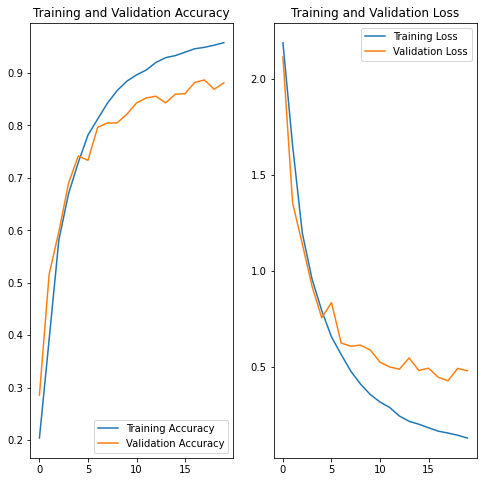

✅


In [65]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [66]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [67]:
results = model_wav.evaluate(test_dataset)
print("✅")

40/40 [==============================] - 5s 115ms/step - loss: 0.4285 - accuracy: 0.8864
✅


In [68]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.428
accuracy value: 88.6409%
✅


In [69]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  on


In [70]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

y_pred: unknown
✅


In [71]:
input_tensor = layers.Input(shape=(40,40,sr))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 40, 40, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 40, 40, 32)   12992       input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 40, 40, 32)   82976       conv2d_113[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_47 (MaxPooling2D) (None, 20, 20, 32)   0           conv2d_114[0][0]                 
_______________________________________________________________________________________

In [72]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [73]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [74]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/20
355/355 [==============================] - ETA: 0s - loss: 2.0318 - accuracy: 0.2750
Epoch 00001: val_loss improved from inf to 1.96505, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 32s 89ms/step - loss: 2.0318 - accuracy: 0.2750 - val_loss: 1.9651 - val_accuracy: 0.4241
Epoch 2/20
355/355 [==============================] - ETA: 0s - loss: 1.3164 - accuracy: 0.5333
Epoch 00002: val_loss improved from 1.96505 to 1.15813, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 32s 90ms/step - loss: 1.3164 - accuracy: 0.5333 - val_loss: 1.1581 - val_accuracy: 0.5982
Epoch 3/20
355/355 [==============================] - ETA: 0s - loss: 0.9567 - accuracy: 0.6690
Epoch 00003: val_loss improved from 1.15813 to 0.90189, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 32s 90ms/step - loss: 0.95

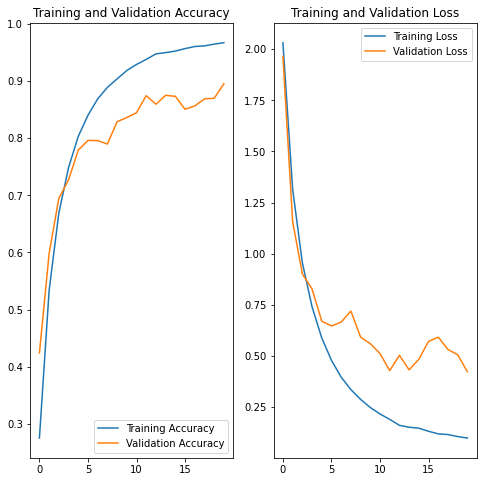

✅


In [75]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [76]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

40/40 [==============================] - 2s 45ms/step - loss: 0.4270 - accuracy: 0.8937
loss value: 0.427
accuracy value: 89.3718%
✅


In [77]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  unknown


In [78]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

y_pred: down
✅


```
$ pip install librosa
```

In [79]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [80]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


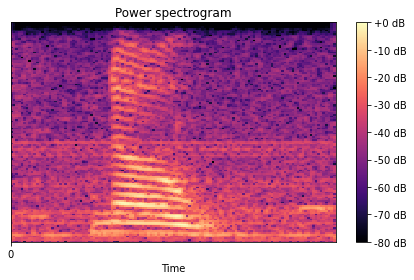

In [81]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### Image를 학습시키듯, Audio를 학습시키면 어떻게 될까. 비교해본 실험.

#### 1. Model 의 입력 데이터 shape을 (8000,1) -> (40,40,5) 로 변경
#### 2. Conv1D -> Conv2D, Maxpool1D-> Maxpool2D로 변경
#### 3. Dropout 0.3->0.5 로 변경
#### 하여 실험해본 결과, 기존의 것 보다 Accuracy가 더 줄어들었다.....
#### Audio에서는 2D 로 학습하는게 좋은 결과를 불러오진 못하는것같다.
